Here is the code we took to perform the segmentation of images. Summarizing a lot the code through an initial view of the color channels tries to find some pixels that are part of the background and some frontground.
This expands on the neighboring pixels to expand the following areas.
The following version of the code is not born to be inserted within a neural network, in fact does not use any TensorFlow nor Pytorch. What we did in fact is take the following functions and convert them into TensorFlow so that you can put them as layers in a network. See the ConvertedSegmentation file for the result

In [1]:
import neptune
from datetime import date
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_cv as tfkv
from tensorflow import keras as tfk
from keras import applications
from tensorflow.keras.applications import MobileNetV2
from keras import layers as tfkl
from tensorflow.keras import mixed_precision
from io import StringIO
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import keras_cv


In [2]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler



In [3]:


def extract_features(sample_dd, position_weight=10):
    """Extract features from the RGB image and return labeled foreground and background pixels."""
    # Get image and scribbles
    img = sample_dd['img']
    fg = sample_dd['scribble_fg']
    bg = sample_dd['scribble_bg']

    # Get image dimensions and flatten image
    H, W, C = img.shape
    img_flat = img.reshape(-1, C)

    # Normalize color features between 0 and 1
    img_flat = img_flat / 255.0

    # Add pixel positions as additional features and apply weighting
    positions = np.indices((H, W)).reshape(2, -1).T
    positions = (positions / np.array([H, W])) * position_weight  # Normalize and apply position weight
    img_flat = np.concatenate([img_flat, positions], axis=1)

    # Flatten scribbles for easy indexing
    fg_flat = fg.flatten()
    bg_flat = bg.flatten()

    # Select pixels labeled as foreground and background
    foreground_pixels = img_flat[fg_flat == 1]
    background_pixels = img_flat[bg_flat == 1]

    # Balance the number of samples
    num_fg = foreground_pixels.shape[0]
    num_bg = background_pixels.shape[0]
    min_samples = min(num_fg, num_bg)
    if num_fg > min_samples:
        idx_fg = np.random.choice(num_fg, size=min_samples, replace=False)
        foreground_pixels = foreground_pixels[idx_fg]
    if num_bg > min_samples:
        idx_bg = np.random.choice(num_bg, size=min_samples, replace=False)
        background_pixels = background_pixels[idx_bg]

    # Create labels: foreground as 1, background as 0
    labels_foreground = np.ones(foreground_pixels.shape[0])
    labels_background = np.zeros(background_pixels.shape[0])

    # Combine features and labels
    features = np.concatenate([foreground_pixels, background_pixels], axis=0)
    labels = np.concatenate([labels_foreground, labels_background], axis=0)

    return features, labels

def segment_image_KNN_sklearn(sample_dd, k=5, threshold=0.3, position_weight=10):
    """Segment images using scikit-learn's KNeighborsClassifier with custom threshold."""
    H, W, C = sample_dd['img'].shape

    # Extract features and labels for training with position weighting
    train_features, train_labels = extract_features(sample_dd, position_weight=position_weight)

    # Flatten test intensities and add weighted pixel positions
    test_features = sample_dd['img'].reshape(-1, C)
    test_features = test_features / 255.0  # Normalize color features
    positions = np.indices((H, W)).reshape(2, -1).T
    positions = (positions / np.array([H, W])) * position_weight  # Normalize and apply position weight
    test_features = np.concatenate([test_features, positions], axis=1)

    # Standardize features
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)

    # Initialize and train the classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_features_scaled, train_labels)

    # Predict probabilities
    probas = knn.predict_proba(test_features_scaled)
    # probas[:, 1] contains the probability of being foreground

    # Apply custom threshold
    labels_test = (probas[:, 1] >= threshold).astype(int)

    # Reshape to image dimensions
    segmented_image_mask = labels_test.reshape(H, W)


    return segmented_image_mask


import matplotlib.pyplot as plt
import numpy as np

def visualize_segmentation(sample_dd, segmented_image_mask):
    """Visualize the original image and the segmented foreground based on the segmented mask."""
    # Get the original image from the input dictionary
    original_image = sample_dd['img']

    # Create a blank image for the segmented pixels
    segmented_pixels = np.zeros_like(original_image)
    # Apply the mask to copy only the segmented foreground pixels from the original image
    segmented_pixels[segmented_image_mask == 1] = original_image[segmented_image_mask == 1]

    # Plot the original and segmented images side-by-side
    plt.figure(figsize=(15, 8))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')

    # Segmented Image (Foreground only)
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_pixels)
    plt.axis('off')

    plt.show()

def visualize_segmentation_NOplot(sample_dd, segmented_image_mask):
    """Visualize the original image and the segmented foreground based on the segmented mask."""
    # Get the original image from the input dictionary
    original_image = sample_dd['img']

    # Create a blank image for the segmented pixels
    segmented_pixels = np.zeros_like(original_image)
    # Apply the mask to copy only the segmented foreground pixels from the original image
    segmented_pixels[segmented_image_mask == 1] = original_image[segmented_image_mask == 1]

    return segmented_pixels

    plt.show()
classes= ["Basophil",
     "Eosinophil",
     "Erythroblast",
     "Immature granulocytes",
     "Lymphocyte",
     "Monocyte",
     "Neutrophil",
     "Platelet"]



In [4]:
def extract_image(img, show=False):
    import matplotlib.pyplot as plt
    import numpy as np
    import random

    treshold = 0.6

    # Convert the tensorflow tensor to a NumPy array
    img = img.numpy()
    # Remove the comment below as it's causing the error
    # img = img.squeeze(0)

    # Normalize the image using the max for each channel
    img_norm = img / np.max(img, axis=(0, 1))

    # Create meshgrid for 3D plotting
    x, y = np.meshgrid(np.arange(img_norm.shape[1]), np.arange(img_norm.shape[0]))

    # Clean each channel
    img = img_norm.copy()  # Create a copy to preserve original
    img_cleaned = img.copy()  # Create a copy to preserve original

    # Plot both original and cleaned images for comparison
    if show:
        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        plt.imshow(img)
        plt.title('Original Image')

    # Clean each channel
    for channel in range(img.shape[2]):  # For each channel
        mask = (img[:, :, channel] < treshold)
        img_cleaned[:, :, channel] = img[:, :, channel] * mask

    if show:
        plt.subplot(122)
        plt.imshow(img_cleaned)
        plt.title('Cleaned Image')
        plt.show()

    # Print statistics for each channel
    for channel in range(img.shape[2]):
        pixels_removed = np.sum((img[:, :, channel] > treshold))
        total_pixels = img[:, :, channel].size
        percentage_removed = (pixels_removed / total_pixels) * 100
        if show:
            print(f"Channel {channel}:")
            print(f"  - Pixels removed: {pixels_removed}")
            print(f"  - Percentage removed: {percentage_removed:.2f}%")
            print(f"  - Max value: {np.max(img_cleaned[:, :, channel]):.3f}")
            print(f"  - Min value: {np.min(img_cleaned[:, :, channel]):.3f}")
            print()

    # Create a mask for pixels that have at least one non-zero channel
    non_zero_mask = np.any(img_cleaned != 0, axis=-1)

    # Create a new image with the same shape as the original
    # Set non-selected pixels to be black (or any color you choose)
    img_with_selected_pixels = np.zeros_like(img)
    img_with_selected_pixels[non_zero_mask] = img[non_zero_mask]

    if show:
        # Plot the resulting image
        plt.imshow(img_with_selected_pixels)
        plt.title('Image with Selected Pixels')
        plt.show()

    # Random sampling for foreground
    random.seed(42)
    size_sample_fg = 100
    fg = np.array(non_zero_mask, dtype=np.uint8)

    non_zero_indices = np.flatnonzero(fg)

    if len(non_zero_indices) >= size_sample_fg:
        selected_indices = np.random.choice(non_zero_indices, size=size_sample_fg, replace=False)
    else:
        if show:
            print(f"Warning: Only {len(non_zero_indices)} non-zero pixels available, selecting all.")
        selected_indices = non_zero_indices

    selected_fg = np.zeros_like(fg)
    selected_fg.flat[selected_indices] = 1

    if show:
        print(f"Shape of selected_fg: {selected_fg.shape}")
        print(f"Number of selected pixels: {np.sum(selected_fg)}")
        plt.imshow(selected_fg, cmap="gray")
        plt.axis("off")
        plt.title('Foreground Selection Mask')
        plt.show()

    # Random sampling for background
    random.seed(42)
    bg = 1 - fg

    bg_non_zero_indices = np.flatnonzero(bg)

    if len(bg_non_zero_indices) >= size_sample_fg:
        selected_bg_indices = np.random.choice(bg_non_zero_indices, size=size_sample_fg, replace=False)
    else:
        if show:
            print(f"Warning: Only {len(bg_non_zero_indices)} non-zero pixels available, selecting all.")
        selected_bg_indices = bg_non_zero_indices

    selected_bg = np.zeros_like(bg)
    selected_bg.flat[selected_bg_indices] = 1

    if show:
        plt.imshow(selected_bg, cmap="gray")
        plt.axis("off")
        plt.title('Background Selection Mask')
        plt.show()

    # Prepare image_test dictionary
    image_test = {
        'img': img.copy(),
        'scribble_fg': selected_fg,
        'scribble_bg': selected_bg
    }

    # Generate segmented image mask
    segmented_image_mask = segment_image_KNN_sklearn(image_test, k=5, position_weight=100)

    if show:
        visualize_segmentation(image_test, segmented_image_mask)
    return image_test, segmented_image_mask

In [ ]:
def preprocess_image_for_extract(image):
    # resize 96x96
    image_resized = tf.image.resize(image, [96, 96])

    # Make sure it’s in RGB
    if image_resized.shape[-1] == 1:  # Se scala di grigi
        image_rgb = tf.image.grayscale_to_rgb(image_resized)
    else:
        image_rgb = image_resized

    # Normalizes values to [0, 255] and cast to uint8
    image_uint8 = tf.clip_by_value(image_rgb, 0, 255)
    image_uint8 = tf.cast(image_uint8, tf.uint8)

    # Remove batch size (if any)
    if image_uint8.ndim == 4 and image_uint8.shape[0] == 1:
        image_uint8 = image_uint8[0]

    return image_uint8

In [ ]:

data = np.load('training_set_cleaned_NODUPLICATE.npz')
X = data['images']
y = data['labels']

# Assuming 'X' and 'y' are defined from the previous code
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1:])
print("Unique labels:", np.unique(y))

Shape of X: (11951, 96, 96, 3)
Shape of y: (11951, 1)
Number of samples: 11951
Number of features: (96, 96, 3)
Unique labels: [0 1 2 3 4 5 6 7]


Here we can see several important information of what the code does. There are different versions of the images processed before reaching the final result, there are the pixels found of bg and fg and the final result.
Obviously in the notebook ConvertedSegmentation, all this is not shown since we only need the final result.

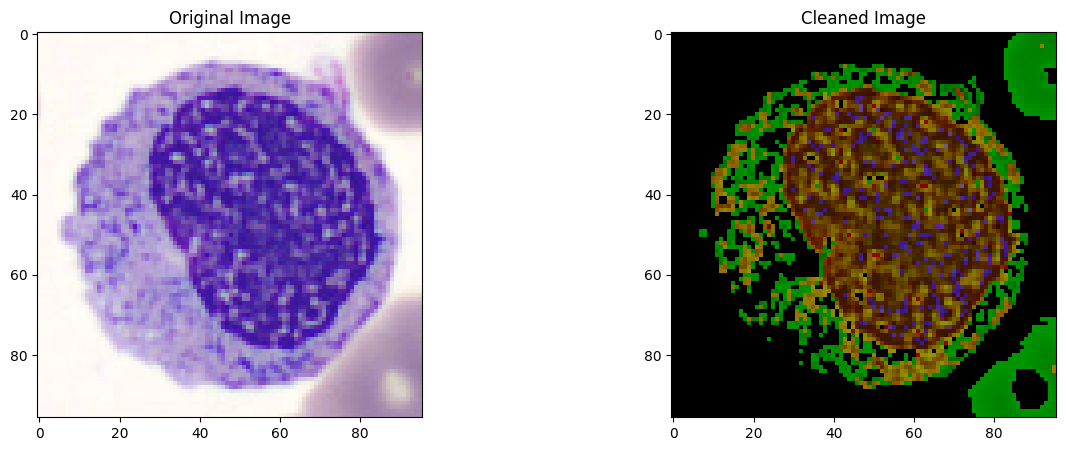

Channel 0:
  - Pixels removed: 5945
  - Percentage removed: 64.51%
  - Max value: 0.596
  - Min value: 0.000

Channel 1:
  - Pixels removed: 4508
  - Percentage removed: 48.91%
  - Max value: 0.596
  - Min value: 0.000

Channel 2:
  - Pixels removed: 8964
  - Percentage removed: 97.27%
  - Max value: 0.598
  - Min value: 0.000



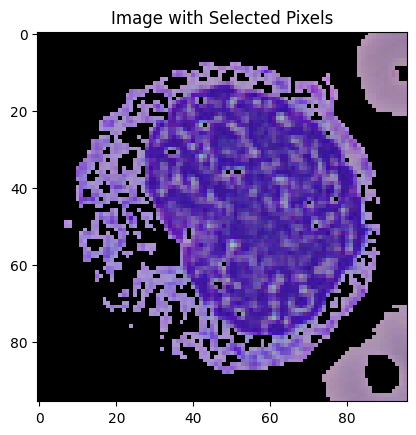

Shape of selected_fg: (96, 96)
Number of selected pixels: 100


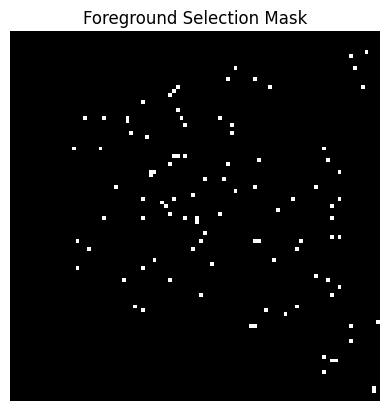

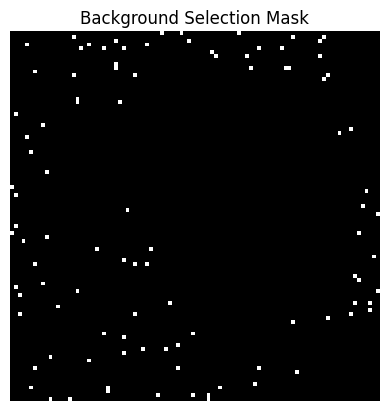

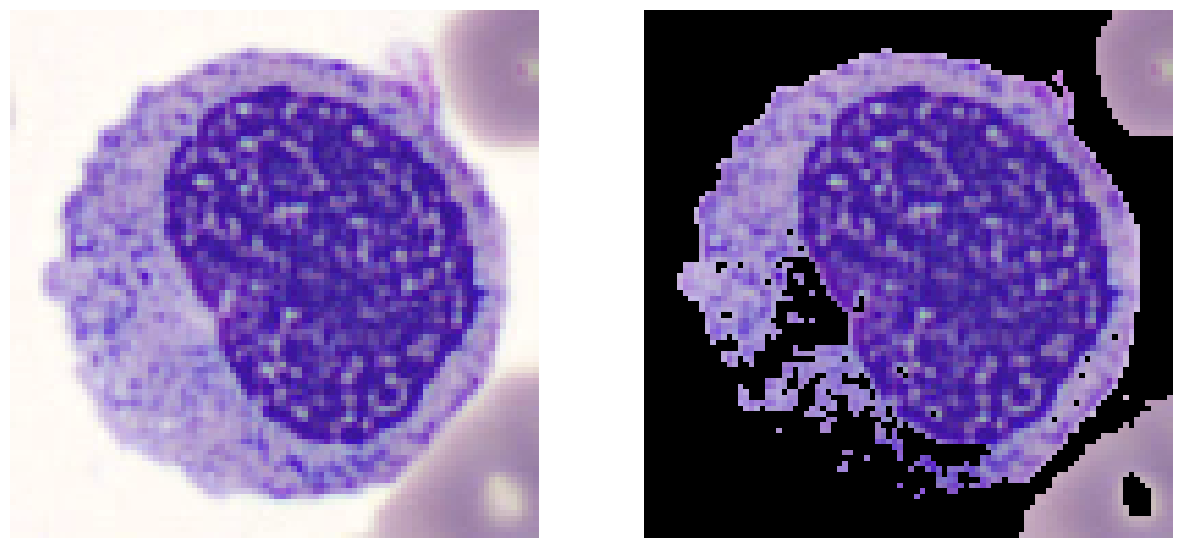

In [24]:

img1 = X[1]
_, mask = extract_image(preprocess_image_for_extract(img1), show=True)